## Jupyter notebook pipeline to dw-google analysis

# Time series analysis

###- [https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python]
- decomposition
- detrend
- cross correlation
- Granger causality test - if one is sequence of another 


In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import functools
import operator
import os
import os.path as op
import numpy as np
import pytrends
from pytrends.request import TrendReq as UTrendReq
from datetime import date
import datetime as d
from collections import Counter
import itertools
from rapidfuzz import process

In [2]:
#load df 

filepath = '../data/interim/clean_keywords_2019-2021_after_RapidFuzz.json'

df = pd.read_json(filepath, orient ='split', compression = 'infer')
#df_clean =df

In [3]:
#INPUT any keyword  and Dates
flat_keywords=list(itertools.chain(*list(df['keywordStringsCleanAfterFuzz'])))
input_keyword = 'Angela Merkel'
start_date='2019-01-01'
end_date='2021-01-01'
#interactive version
# pre_keyword = remove_spaces(str(input('Please input keyword to be analyzed:\n')).lower())
# start_date = str(input('Please input start date (YYYY-MM-DD):\n'))
# end_date = str(input('Please input end date (YYYY-MM-DD):\n'))
#df_clean = truncate_data(df_clean, start_date, end_date)

#match it to out database
selected_keyword=process.extractOne(input_keyword, flat_keywords)[0]
selected_keyword

'angela merkel'

In [4]:
#get google method
GET_METHOD='get'


headers = {
    'authority': 'trends.google.com',
    'accept': 'application/json, text/plain, */*',
    'accept-language': 'el-GR,el;q=0.9,en;q=0.8,es;q=0.7',
    'content-type': 'application/json;charset=UTF-8',
    'cookie': '__utma=10102256.1937595387.1677588086.1677588086.1678441622.2; __utmc=10102256; __utmz=10102256.1678441622.2.2.utmcsr=trends.google.com|utmccn=(referral)|utmcmd=referral|utmcct=/; __utmt=1; __utmb=10102256.13.9.1678442016068; CONSENT=YES+GB.en-GB+; HSID=AwrWd8APwv-yBWgzh; SSID=AeXCoum7ArBP5_-aa; APISID=CH4IjtEJhVzXdXGB/AFPE6uuFtOUDiSjnb; SAPISID=FcPgZF83fs0zxFml/Ad59_bwdrgg_kZ4q4; __Secure-1PAPISID=FcPgZF83fs0zxFml/Ad59_bwdrgg_kZ4q4; __Secure-3PAPISID=FcPgZF83fs0zxFml/Ad59_bwdrgg_kZ4q4; SID=TwhPHvTugfJu62Xh-HCJkOIPdoEDrL6q-6Eu9itbEI8mmKw9wzJdgT6c48lYdsNyN4E5xA.; __Secure-1PSID=TwhPHvTugfJu62Xh-HCJkOIPdoEDrL6q-6Eu9itbEI8mmKw9mFTrJ0j2r8zMRcq3v-A7Dg.; __Secure-3PSID=TwhPHvTugfJu62Xh-HCJkOIPdoEDrL6q-6Eu9itbEI8mmKw9xQIlYIR6TyZD2qXkeuopSA.; OGPC=19031986-1:; AEC=ARSKqsLpZW_sbZN2NdijlA8HPzuRHa1TPtYLHLGgaOIZpt8oJZL9PYZZYQ; SEARCH_SAMESITE=CgQI4ZcB; 1P_JAR=2023-03-10-09; NID=511=bYRTpZST7bJyL0z371h4Y79EMA1j9QqQFUpi8vJsSmiWdINx5gKruSDljEBAFfs9FYsxRrmP7vulT_MdtU2xEXQSW837vsgNY9s0i2WZAeFETmMEDrju3d_HgA2Wxy5DrFrIOaOiFu6LkpD7pY4wF4qrMZ38BzvW4NkYX_fUI7bFzHXsg24iHara1hPmPIXOSl6wQgsssfGHUntOI9PgY_eXaAEJbY7VgTr1hjNvEDlFSYOuzLvHSzo9kX9ALXA5-WOICbuLdAucZc3hJKo1dUKM51JCkzLsUHm99MWA86Icz-dmMW8ybQZhEUd2YgsBHHn5MV8uSVpcZ53n4_KL7r6sOpfWZ0ZXairmL3NH-hHz4Vyq; _gid=GA1.3.1682047475.1678441583; OTZ=6935626_48_48_123900_44_436380; _gat_gtag_UA_4401283=1; _ga=GA1.3.1937595387.1677588086; SIDCC=AFvIBn_I_znBUYDEoxfE1jUbrp_F8T607DZhlzI9o_gQoZmA4OxNjglOrH8Q8er3Cv4uzoWYkX9Z; __Secure-1PSIDCC=AFvIBn_Nhc9nywxJ_UrRYogvErcX48ygHEiBzjRRZtPe-mIwBTe_M7UbvKR4d-rAuhYyGJi-Dm0; __Secure-3PSIDCC=AFvIBn8vpeAOp5e0oAWBAETEzSClsyQlm3vQJhAQP7T7Z51q1K7zHDm_-CSGFEPasFw0sRHoJDU; _ga_VWZPXDNJJB=GS1.1.1678441583.2.1.1678442016.0.0.0',
    'origin': 'https://trends.google.com',
    'referer': 'https://trends.google.com/trends/explore?date=now%201-d&q=Adele&hl=en-GB',
    'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
    'sec-ch-ua-arch': '"x86"',
    'sec-ch-ua-bitness': '"64"',
    'sec-ch-ua-full-version': '"110.0.5481.177"',
    'sec-ch-ua-full-version-list': '"Chromium";v="110.0.5481.177", "Not A(Brand";v="24.0.0.0", "Google Chrome";v="110.0.5481.177"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-model': '',
    'sec-ch-ua-platform': '"macOS"',
    'sec-ch-ua-platform-version': '"13.2.1"',
    'sec-ch-ua-wow64': '?0',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
    'x-client-data': 'CIq2yQEIprbJAQjEtskBCKmdygEIkufKAQiVocsBCPyqzAEI9/XMAQib/swBCI6MzQEIlZbNAQiols0BCOGXzQEI5JfNAQjzl80BCMyYzQEI2JjNAQjzmc0BCLSazQEI0uGsAg==',
}


class TrendReq(UTrendReq):
    def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
        return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)




In [5]:
#extract google search for the keyword
def get_interest_over_time(keyword, start_date = '2019-01-01', end_date=f'{date.today()}'):
    #keywords needs to be a list 
    #need to make sure the total number of characters is less than 100 for Google and terms are fewer than 5 
    # terms = 0
    # chars = 0
    # for word in keywords:
    #     chars += len(word)
    #     if chars > 99:
    #         break
    #     else:
    #         terms += 1
    # if terms > 5:
    #     terms = 5
    # keywords = keywords[:terms]
    print(keyword)
    if len(keyword)>99:
        print('KEYWORD IS TOO LONG FOR THIS SEARCH')
        return None
    
    #let's get python trends 
    pytrend = TrendReq(                    
    # proxies=['https://34.203.233.13:80','https://35.201.123.31:880'], 
    # #hl='en-US', tz=360, timeout=(10,25)
    retries=2, backoff_factor=0.1, requests_args={'verify':False})
    google_df = pytrend.build_payload(kw_list= [keyword], timeframe= '{} {}'.format(str(start_date),str(end_date)))
    google_df = pytrend.interest_over_time()
    if 'isPartial' in google_df.columns:
        google_df = google_df.drop('isPartial', axis = 'columns')

    return google_df

## try with replace

In [6]:
df.head()

,id,lastModifiedDate,keywordStrings,keywordStringsCleanAfterFuzz
0,46912921,2019-01-01T03:57:28.904Z,"[NASA, OSIRIS-REx, Bennu, asteroid]","[nasa, osiris-rex, bennu, asteroid]"
1,46911356,2019-01-01T06:11:50.527Z,"[English Channel, migration, boats, illegal im...","[english channel, migration, boats, illegal im..."
2,46909694,2019-01-01T06:14:35.563Z,"[Brazil, Jair Bolsonaro, Chicago economics, Ha...","[brazil, jair bolsonaro, chicago economics, ha..."
3,46912694,2019-01-01T08:26:11.599Z,"[Japan, Tokyo, Harajuku, attack]","[japan, tokyo, harajuku, attack]"
4,46910092,2019-01-01T09:05:00.736Z,"[Asia, Bangladesh, elections, Kamal Hossain, S...","[asia, bangladesh, elections, kamal hossain, s..."


In [7]:
#get DW keywords
def get_dw_timeseries_FT(df_clean, keyword, start = '2019-01-01', end='2021-01-01'):

    not_keyword_indices = [] #TODO: do this without a loop (create extra boolean column and assign True if keyword is there)
    for i, row in enumerate(df_clean['keywordStringsCleanAfterFuzz']):
        if keyword not in row:
            not_keyword_indices.append(i)

    df_clean = df_clean.drop(not_keyword_indices)
    df_clean['lastModifiedDate'] = pd.to_datetime(df_clean['lastModifiedDate'])
    df_clean.set_index('lastModifiedDate', inplace = True)
    df_clean = df_clean.loc[start:end]
    output = df_clean.resample('1W').count()['id']
    return output

In [8]:
import plotly.graph_objects as go

def get_interest_over_time_plot(google_df,dw_mentions,selected_keyword):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
    x=google_df.resample('1W').mean()[selected_keyword].index,
    y=google_df.resample('1W').mean()[selected_keyword],
    name="Google Search Weekly Relative Average"       # this sets its legend entry
    ))


    fig.add_trace(go.Scatter(
    x=google_df.resample('1W').mean()[selected_keyword].index,
    y=dw_mentions,
    name="Number of DW articles per week"
    ))

    fig.update_layout(
    title="Plot Title",
    xaxis_title="Date",
    yaxis_title="Y Axis Title",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"))

    fig.show()
    return fig



In [9]:
start='2019-01-01'
end='2021-01-01'
google_df = get_interest_over_time(selected_keyword, start_date = start, end_date=end)
dw_mentions = get_dw_timeseries_FT(df, selected_keyword, start = start, end=end)
line_fig = get_interest_over_time_plot(google_df,dw_mentions,selected_keyword)
#line_fig

angela merkel


/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  Inse

In [10]:
#assign date as index
df['lastModifiedDate'] = pd.to_datetime(df['lastModifiedDate'])
df.set_index('lastModifiedDate', inplace = True)

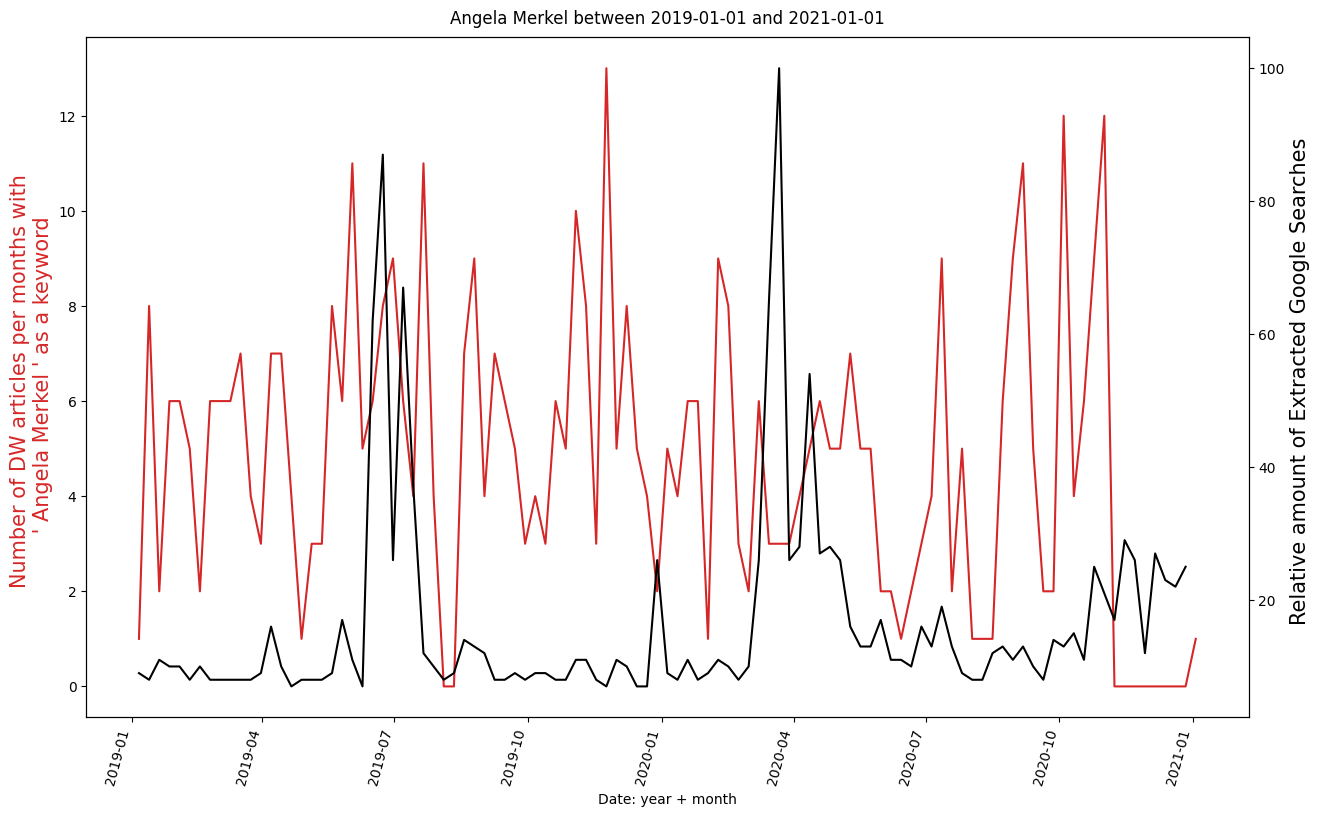

In [36]:
def plot_timeseries_dw_google(input_keyword,x, y, x1, y1, xlabel='Date: year + month', dpi=100,fontsize=15):
    
    fig,ax=plt.subplots(figsize=(15,10), dpi=dpi)
    plt.gca().set(title= str(input_keyword)+' between '+start+' and '+ end, xlabel=xlabel)
    ax.set_ylabel(ylabel='Number of DW articles per months with \n \' ' + input_keyword + ' \' as a keyword', color = 'tab:red',fontsize = fontsize)
    ax2 = ax.twinx()
    ax2.set_ylabel('Relative amount of Extracted Google Searches ', color = 'black', fontsize = fontsize)
    ax.plot(x, y, color='tab:red')
    ax2.plot(x1, y1, color='black')
    fig.autofmt_xdate(rotation=75)
    
    #ax.xticks(fontsize=6, rotation=60)
    plt.show()

plot_timeseries_dw_google(input_keyword, x=dw_mentions.index, y=dw_mentions, x1=google_df.index, y1=google_df )

In [12]:
# merge DW keyword count and google searches 
#    into one dataframe based on datetime index

google_searches = get_interest_over_time(selected_keyword, start_date = start_date, end_date=end_date)
google_searches.index=pd.to_datetime(google_searches.index).tz_localize('utc') #add timezone if missing

df_plot=google_searches.merge(pd.DataFrame(dw_mentions),left_index=True, right_index=True) #merge dataframes

angela merkel


/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/home/anya_m/Documents/venv/lib64/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/home/anya_m/Documents/venv/lib64/python3.7/site-pac

In [13]:
#scaling of the two time series
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#df_plot.iloc[[:,1]]
df_plot['scaled_kw']=scaler.fit_transform(df_plot[['id']])
df_plot['scaled_google']=scaler.fit_transform(df_plot[[selected_keyword]])
#scaler.fit_transform(df_plot.values[:,1])

#df_plot


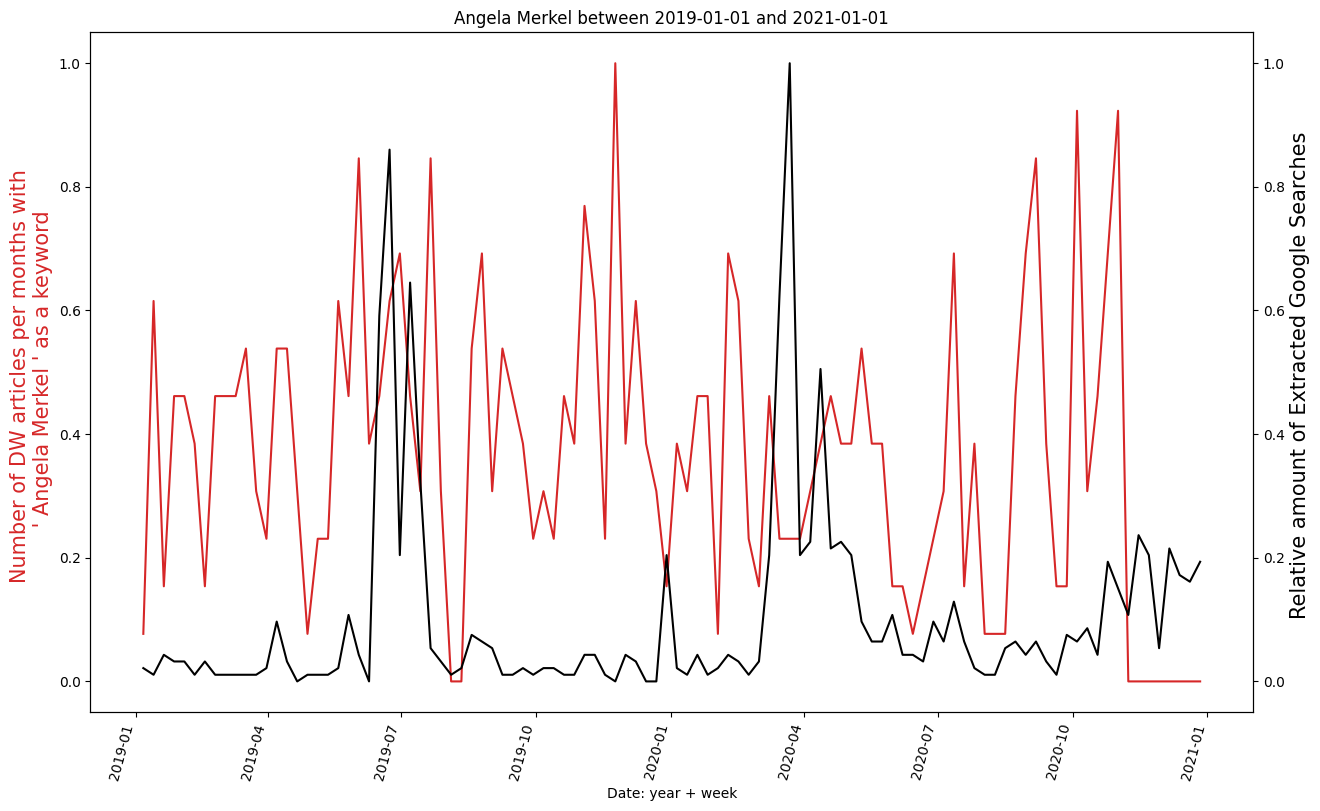

In [14]:
#plotting of thw two scaled timeseries
plot_timeseries_dw_google(input_keyword, x=df_plot.index, y=df_plot['scaled_kw'], x1=df_plot.index, y1=df_plot['scaled_google'] )

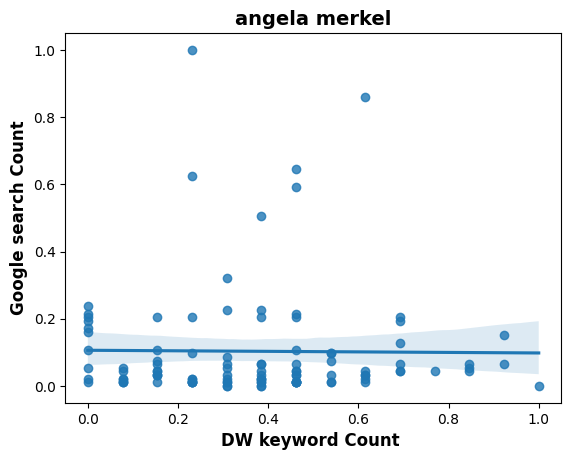

In [15]:
sns.regplot(data = df_plot, x = df_plot.iloc[:,2], y = df_plot.iloc[:,3])
plt.title(selected_keyword, weight='bold', fontsize = 14)
plt.ylabel('Google search Count', weight='bold', fontsize = 12)
plt.xlabel('DW keyword Count ', weight='bold', fontsize = 12)
plt.show()

In [16]:
import scipy
scipy.stats.pearsonr(df_plot.iloc[:,2],df_plot.iloc[:,3])


(-0.01120647123320331, 0.910104839973778)

In [17]:
scipy.stats.pearsonr(df_plot.iloc[:,0],df_plot.iloc[:,1])

(-0.011206471233203294, 0.910104839973778)

In [18]:
df_plot.head()

,angela merkel,id,scaled_kw,scaled_google
2019-01-06 00:00:00+00:00,9,1,0.076923,0.021505
2019-01-13 00:00:00+00:00,8,8,0.615385,0.010753
2019-01-20 00:00:00+00:00,11,2,0.153846,0.043011
2019-01-27 00:00:00+00:00,10,6,0.461538,0.032258
2019-02-03 00:00:00+00:00,10,6,0.461538,0.032258


# Granger test

In [19]:
#!pip3 install statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

mix_df = pd.DataFrame({'dw':df_plot.iloc[:,2], 'google':df_plot.iloc[:,3]})
gc_res = grangercausalitytests(mix_df, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1921  , p=0.6621  , df_denom=100, df_num=1
ssr based chi2 test:   chi2=0.1978  , p=0.6565  , df=1
likelihood ratio test: chi2=0.1977  , p=0.6566  , df=1
parameter F test:         F=0.1921  , p=0.6621  , df_denom=100, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2823  , p=0.7547  , df_denom=97, df_num=2
ssr based chi2 test:   chi2=0.5937  , p=0.7432  , df=2
likelihood ratio test: chi2=0.5920  , p=0.7438  , df=2
parameter F test:         F=0.2823  , p=0.7547  , df_denom=97, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7559  , p=0.5217  , df_denom=94, df_num=3
ssr based chi2 test:   chi2=2.4366  , p=0.4869  , df=3
likelihood ratio test: chi2=2.4076  , p=0.4922  , df=3
parameter F test:         F=0.7559  , p=0.5217  , df_denom=94, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5594  , p=0.6927  , df

In [20]:
df_plot.head()

,angela merkel,id,scaled_kw,scaled_google
2019-01-06 00:00:00+00:00,9,1,0.076923,0.021505
2019-01-13 00:00:00+00:00,8,8,0.615385,0.010753
2019-01-20 00:00:00+00:00,11,2,0.153846,0.043011
2019-01-27 00:00:00+00:00,10,6,0.461538,0.032258
2019-02-03 00:00:00+00:00,10,6,0.461538,0.032258


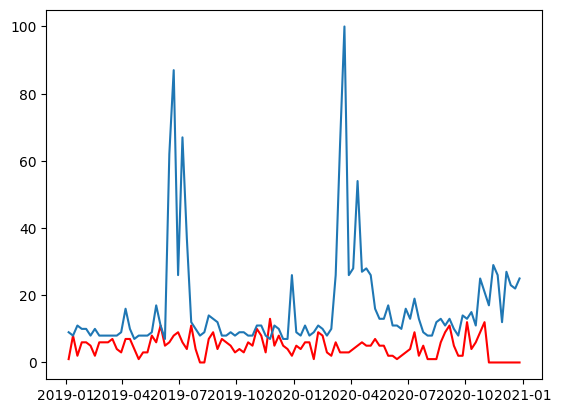

In [21]:
#let's subtract the meean from each signal 
dw=df_plot['id']
google=df_plot[selected_keyword]

dw_demean = dw-np.mean(dw)
google_demean = google-np.mean(google)

plt.plot(dw,'red')
plt.plot(google)

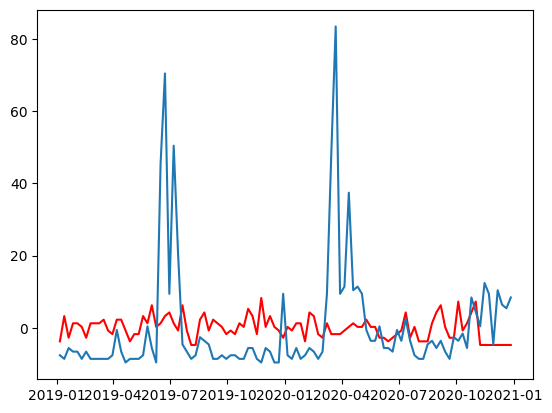

In [22]:
plt.plot(dw_demean,'red')
plt.plot(google_demean)


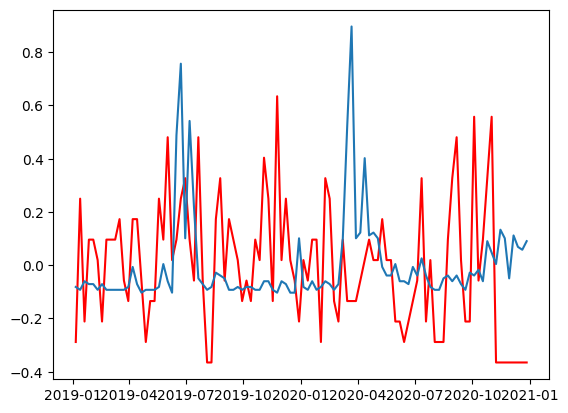

In [23]:
dw_scaled=df_plot['scaled_kw']
google_scaled=df_plot['scaled_google']

dw_scaled_demean = dw_scaled-np.mean(dw_scaled)
google_scaled_demean = google_scaled-np.mean(google_scaled)

plt.plot(dw_scaled_demean,'red')
plt.plot(google_scaled_demean)

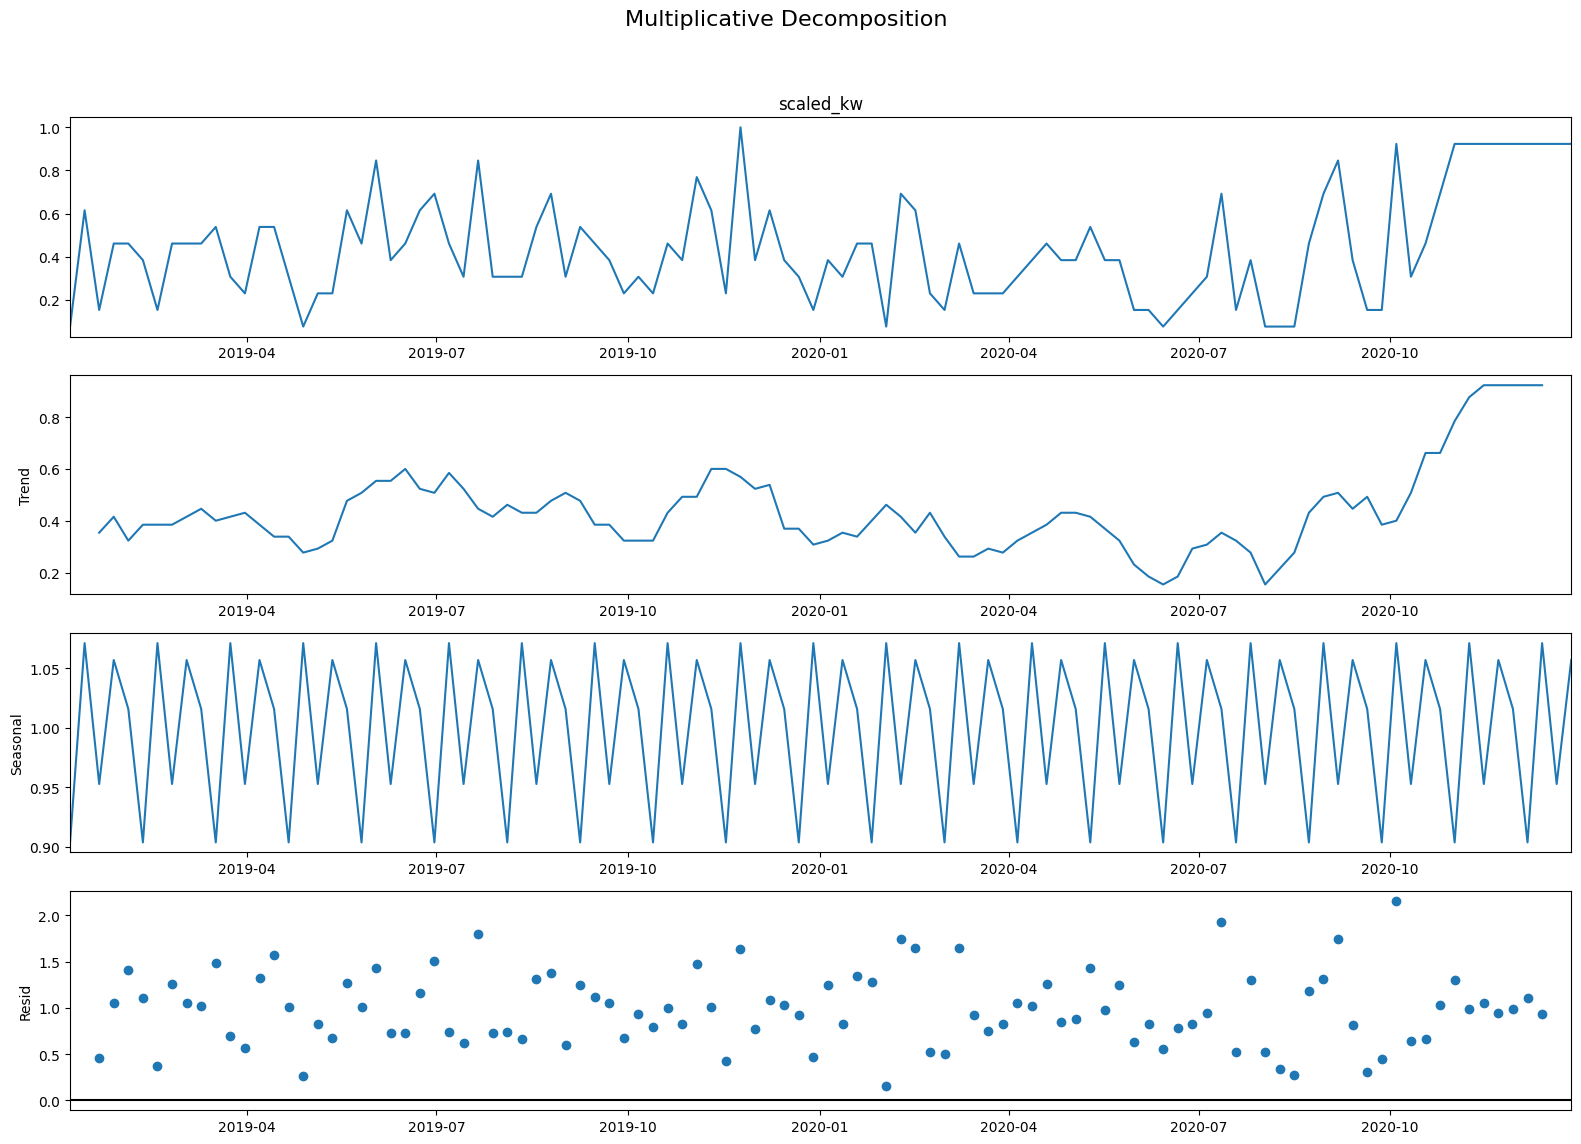

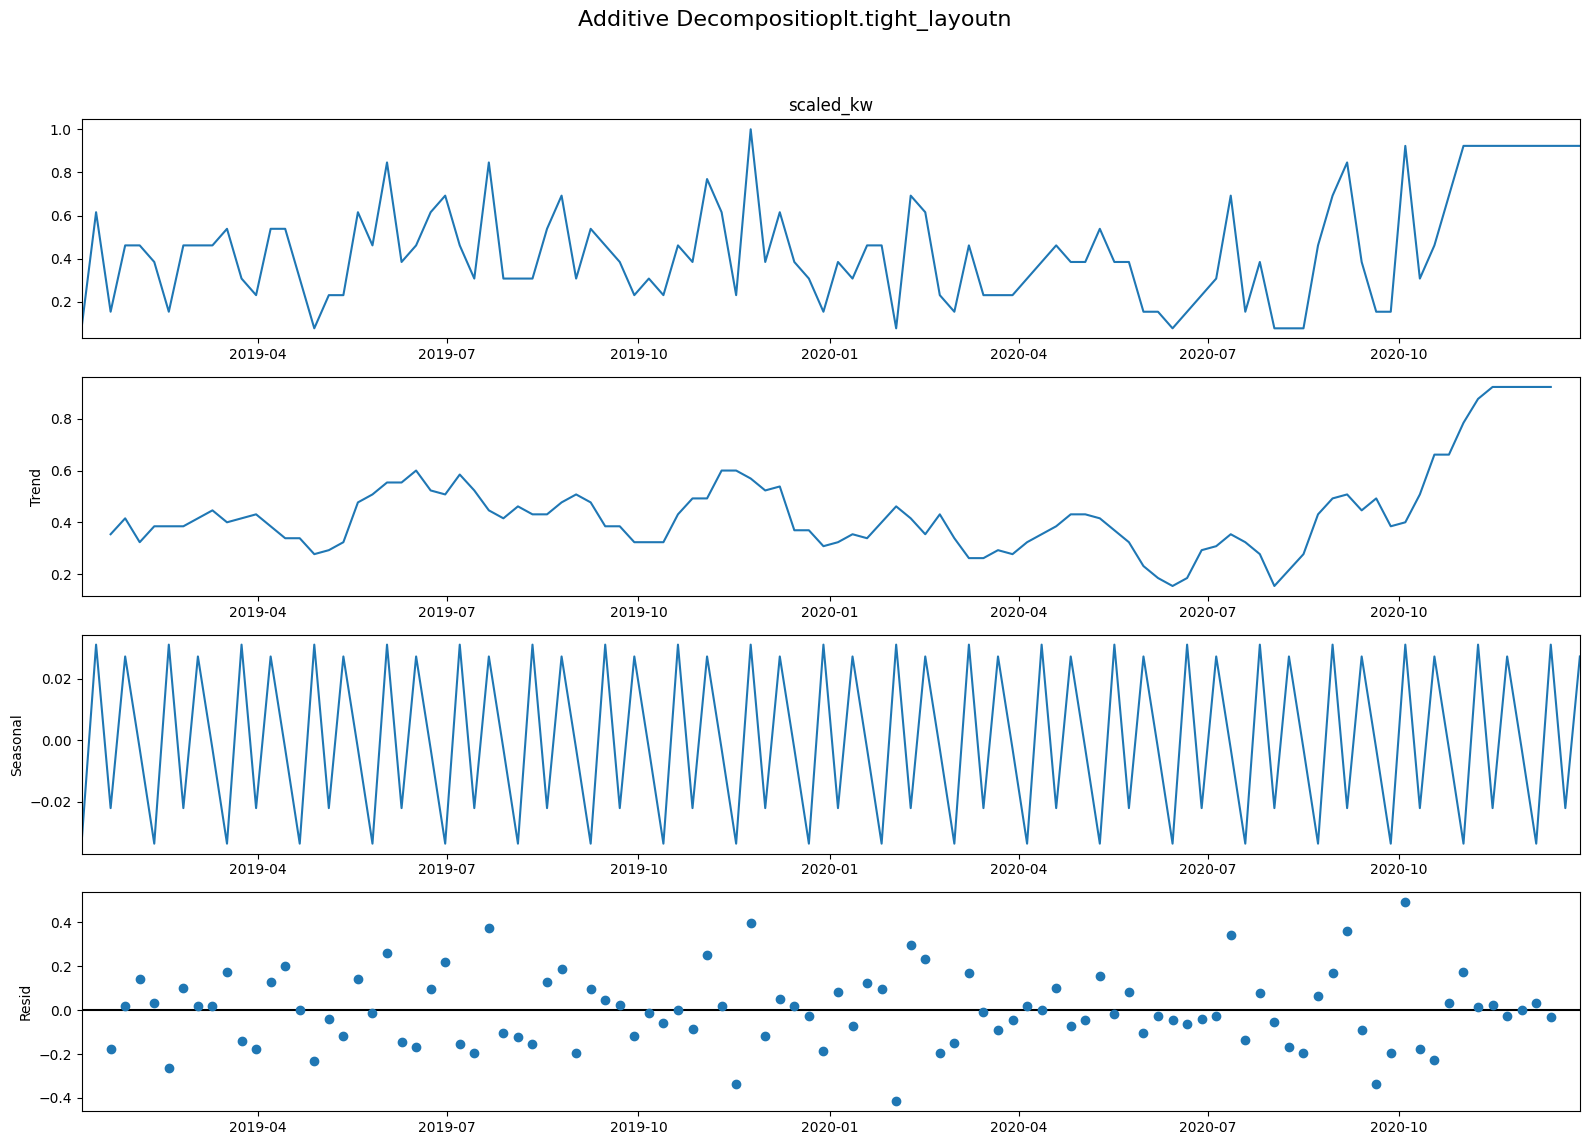

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def decomposition_plot(dw, period=30):
    
    # Multiplicative Decomposition 
    multiplicative_decomposition = seasonal_decompose(dw, model='multiplicative', period=period)

    # Additive Decomposition
    additive_decomposition = seasonal_decompose(dw, model='additive', period=period)

    # Plot
    plt.rcParams.update({'figure.figsize': (16,12)})
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    additive_decomposition.plot().suptitle('Additive Decompositioplt.tight_layoutn', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

dw_scaled_nonull=dw_scaled.replace(0, None)
google_scaled_nonull=google_scaled.replace(0, None)

decomposition_plot(dw_scaled_nonull,period=5)

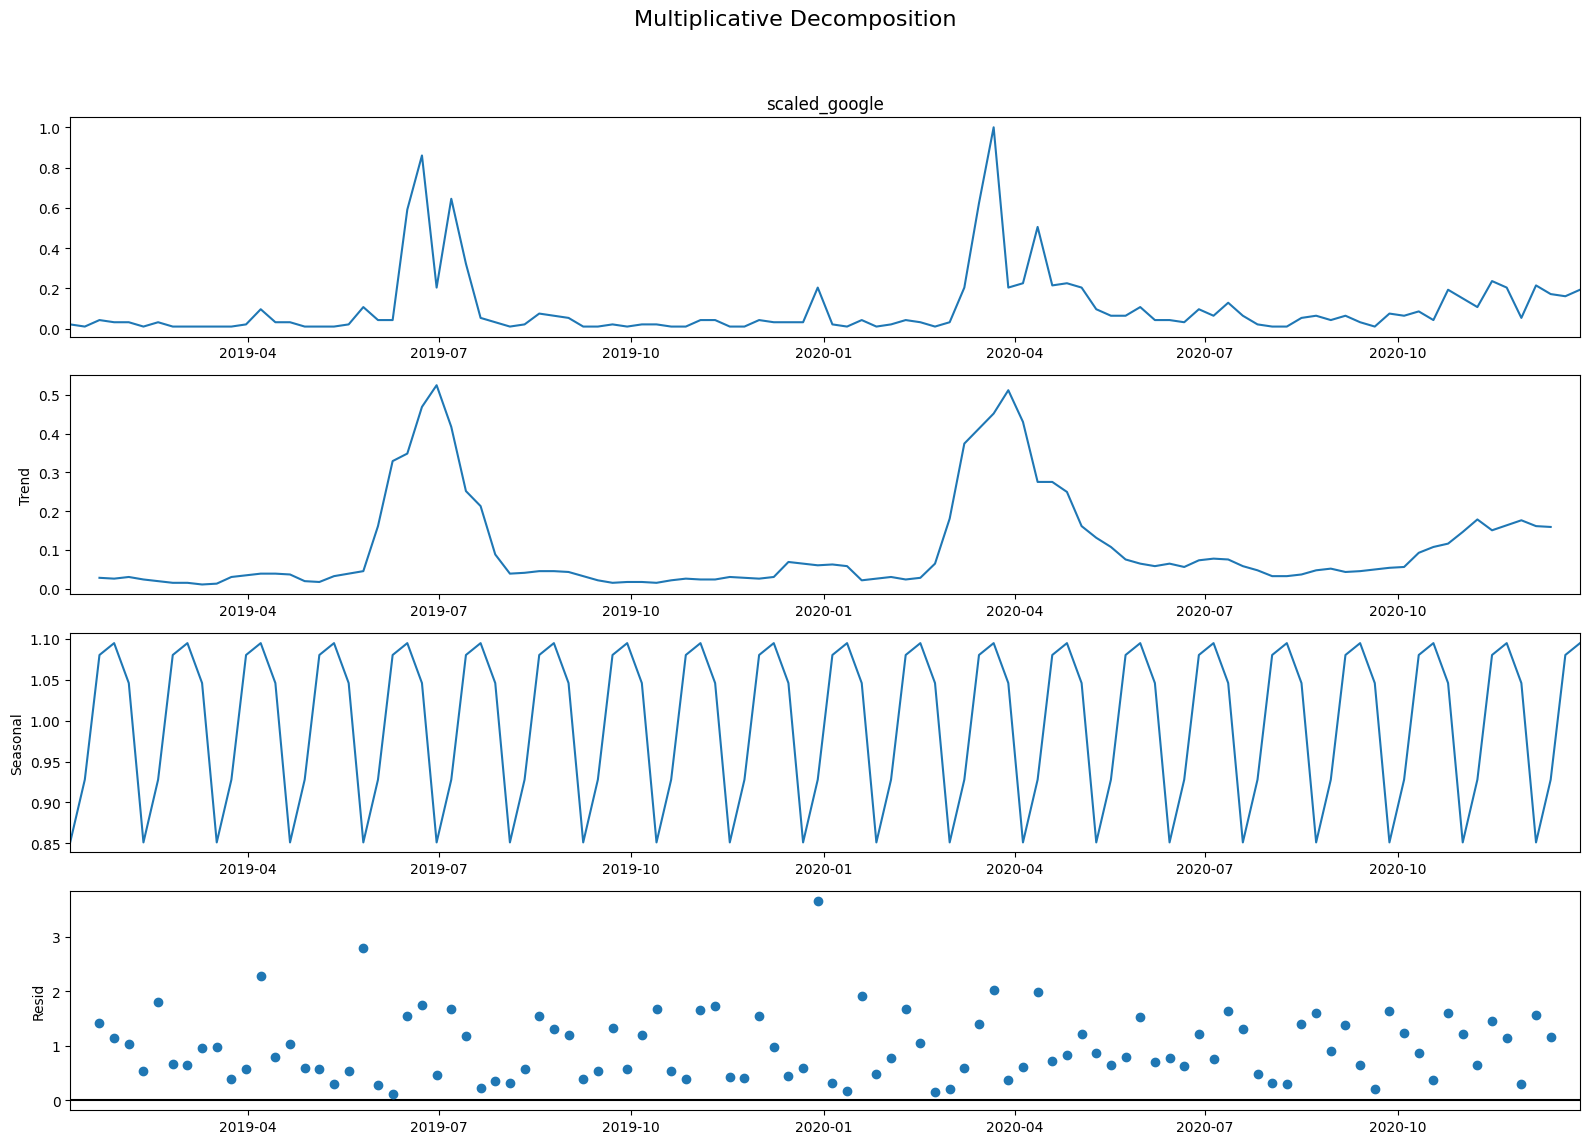

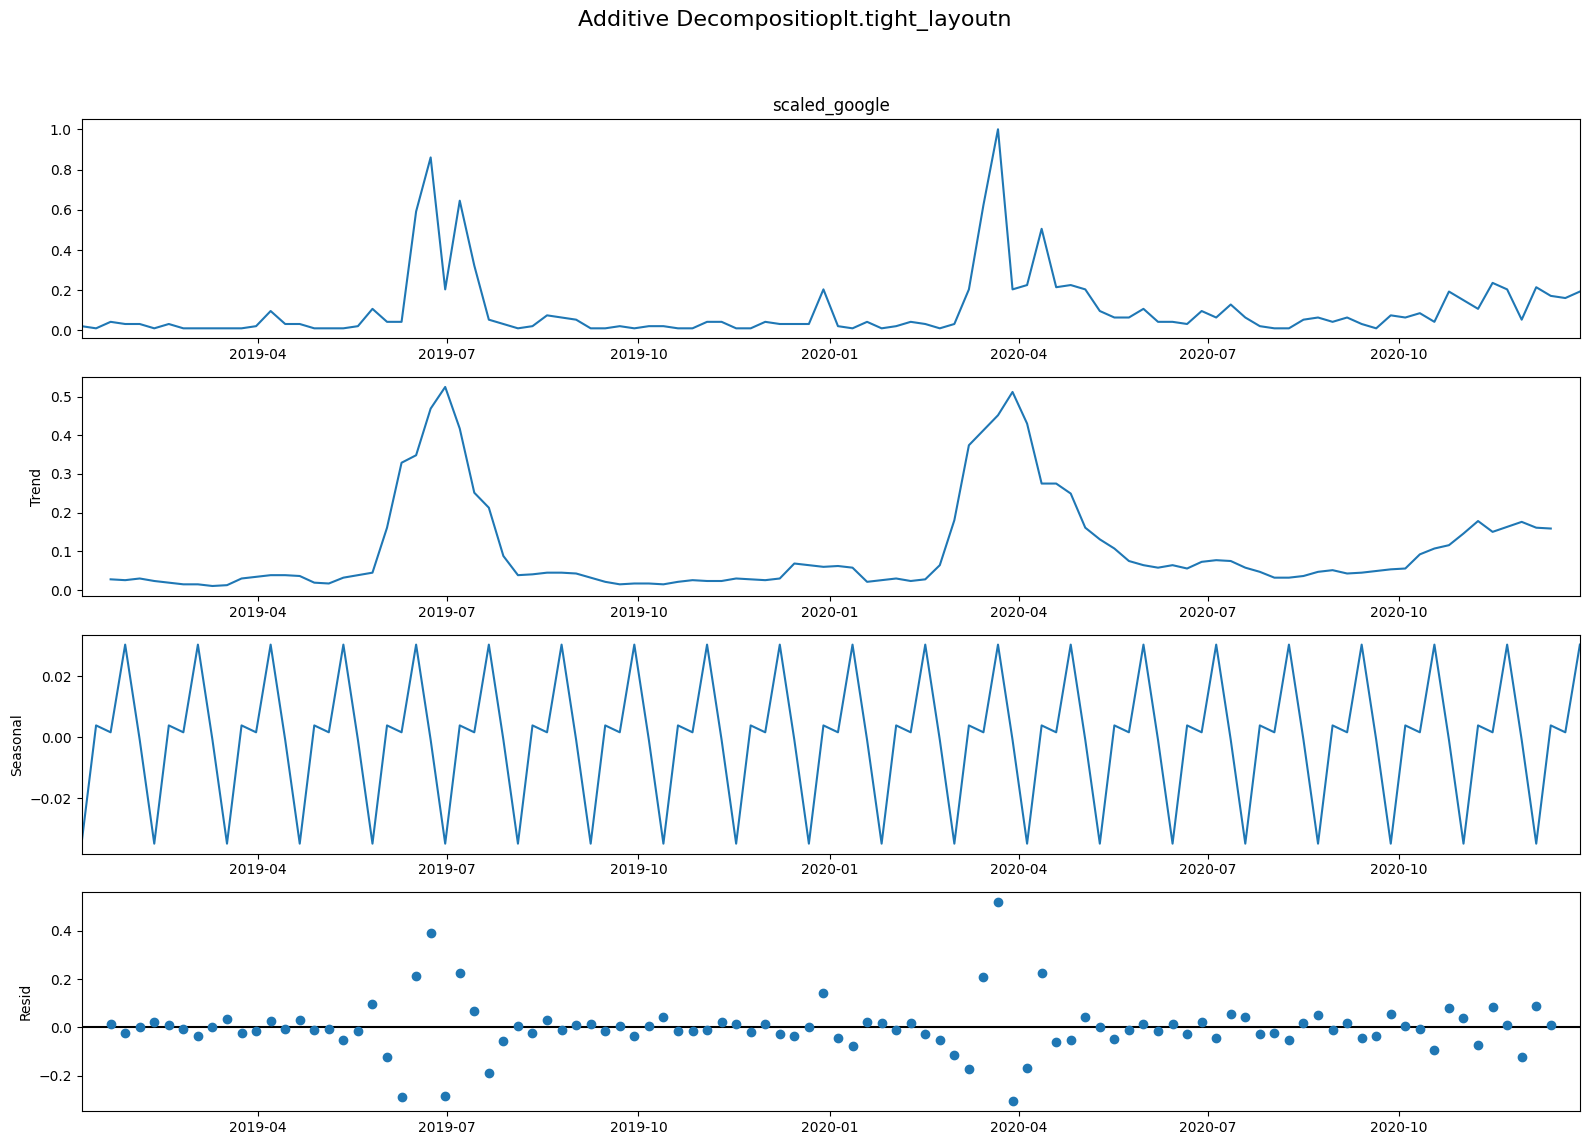

In [25]:
decomposition_plot(google_scaled_nonull,period=5)

Text(0.5, 1.0, 'angela merkel from Google (black) and DW (red) detrended by subtracting the least squares fit')

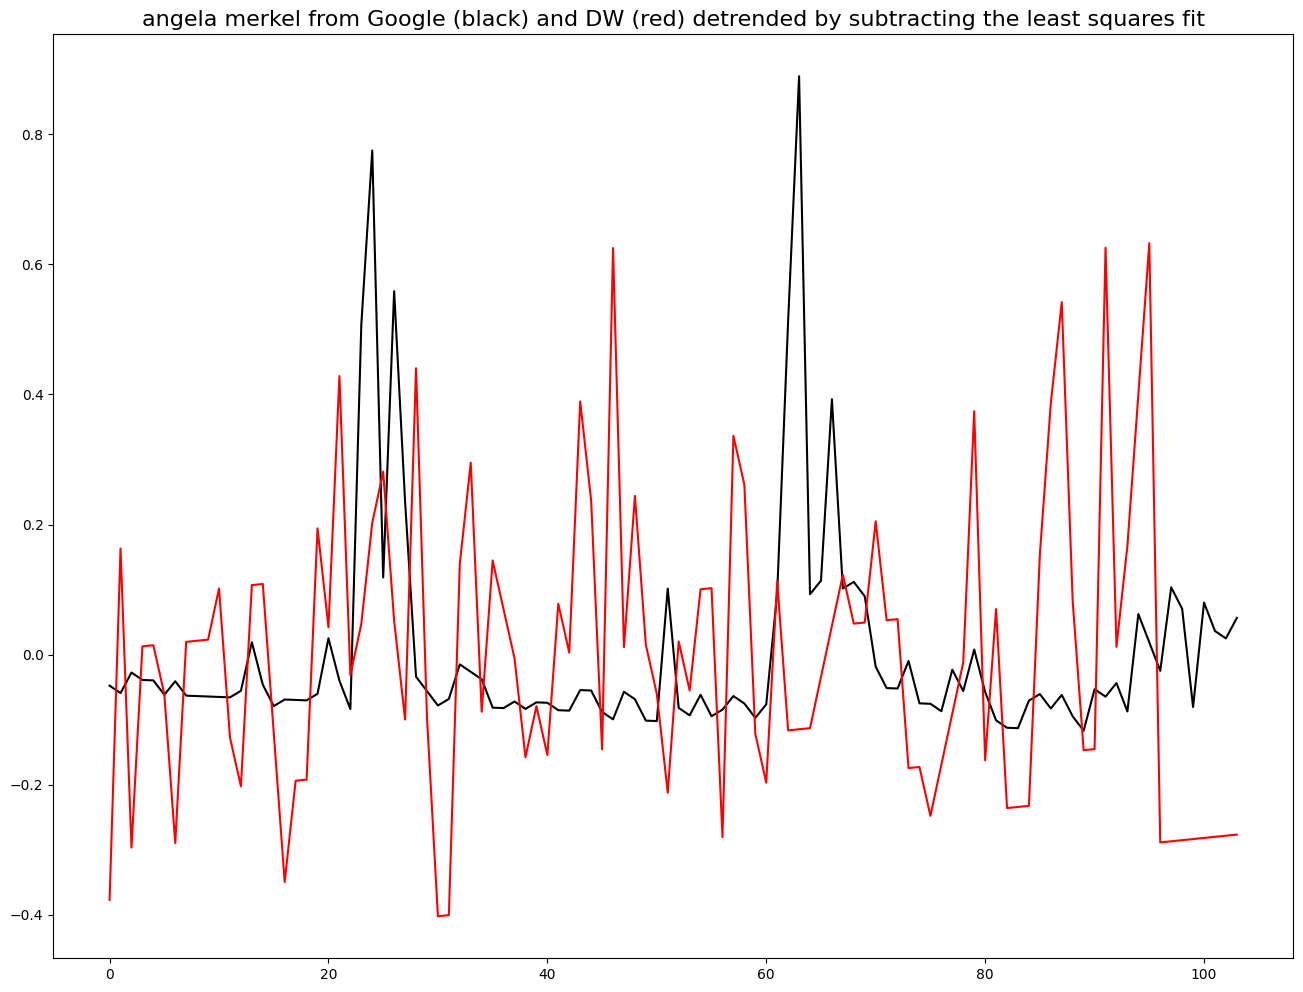

In [26]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended_google = signal.detrend(google_scaled)
detrended_dw = signal.detrend(dw_scaled)
plt.plot(detrended_google,'black')
plt.plot(detrended_dw,'red')
plt.title(selected_keyword+' from Google (black) and DW (red) detrended by subtracting the least squares fit', fontsize=16)

In [27]:
#calculate crosscorelation
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_kw = ccf_values(detrended_dw, detrended_google)
ccf_kw

array([-5.26835637e-03, -4.16777424e-05, -6.52689362e-03, -7.64351563e-03,
        8.36924210e-03, -1.63502532e-02, -4.92434898e-03, -6.99834011e-04,
       -1.37989845e-02, -6.54960743e-03,  1.64607114e-02, -1.15820472e-02,
        1.57828938e-03,  8.55693062e-03,  7.42563652e-03,  5.32520867e-03,
        1.92325692e-02,  2.41921148e-03, -2.35204995e-03,  1.63808169e-02,
        1.87602676e-02,  1.43925151e-02,  2.20300911e-02,  1.11227151e-02,
        1.28981792e-02,  1.54531872e-02,  2.97977267e-02,  4.20687847e-02,
        3.17398633e-02,  2.49702515e-02,  2.70631056e-02,  2.71560470e-02,
        3.97983129e-03,  2.00445472e-02,  1.64374508e-02, -1.13128581e-02,
       -2.94553017e-02, -3.68323901e-02,  2.18540336e-03, -4.90191134e-02,
       -1.17605154e-01, -3.10738241e-02, -8.22628664e-02, -5.85876377e-02,
        1.30535090e-02, -4.35136462e-03, -6.34452858e-02, -3.02279462e-02,
       -2.44872529e-03,  2.78822945e-02,  2.45033357e-02,  2.35563377e-03,
       -6.44017391e-02, -

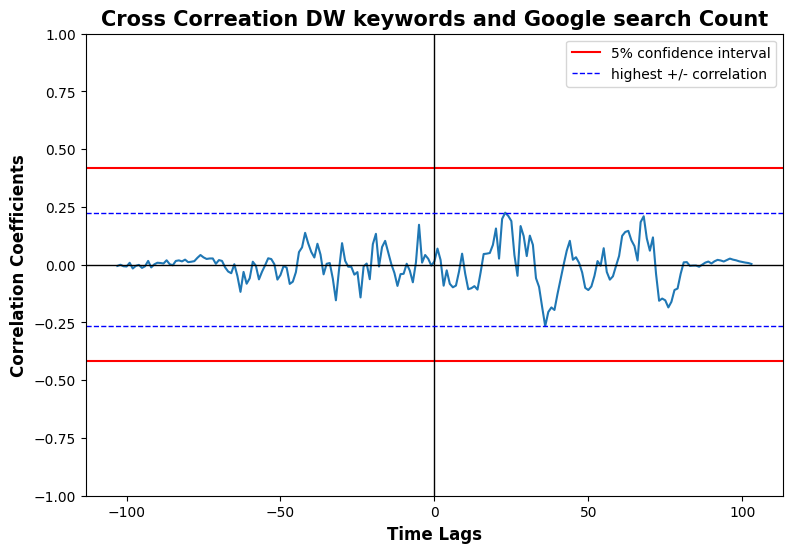

In [28]:
lags = signal.correlation_lags(len(detrended_dw), len(detrended_google))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation DW keywords and Google search Count', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_kw)

(<Figure size 1000x1000 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

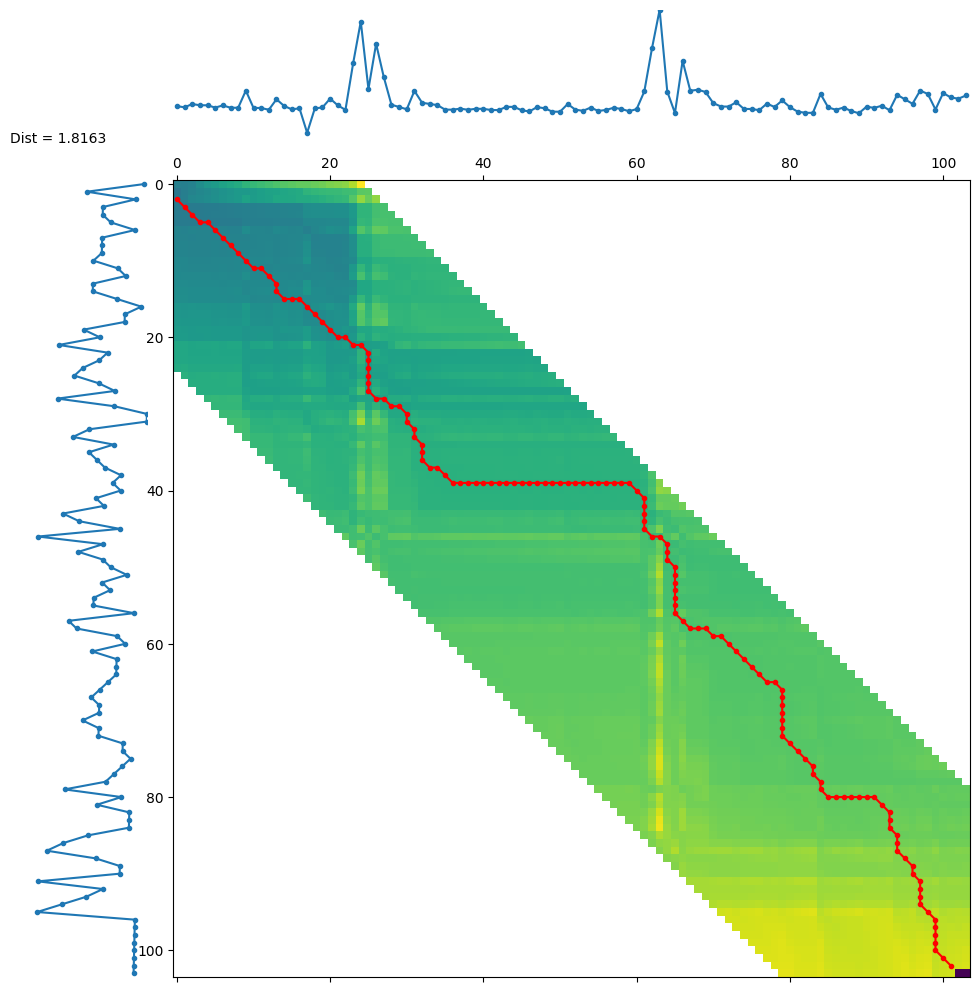

In [29]:
#Calculating distance between two timesries: Dynamic Time warping
#The matrix with all warping paths can be visualised as follows: 
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
x = np.arange(0, 20, .5)
s1 = detrended_dw
s2 = detrended_google
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [30]:
#calculating distance between the two timeseries
d = dtw.distance_fast(detrended_dw, detrended_google)
d

1.872998160106889

Text(0.5, 1.0, 'angela merkel detrended by subtracting the trend component')

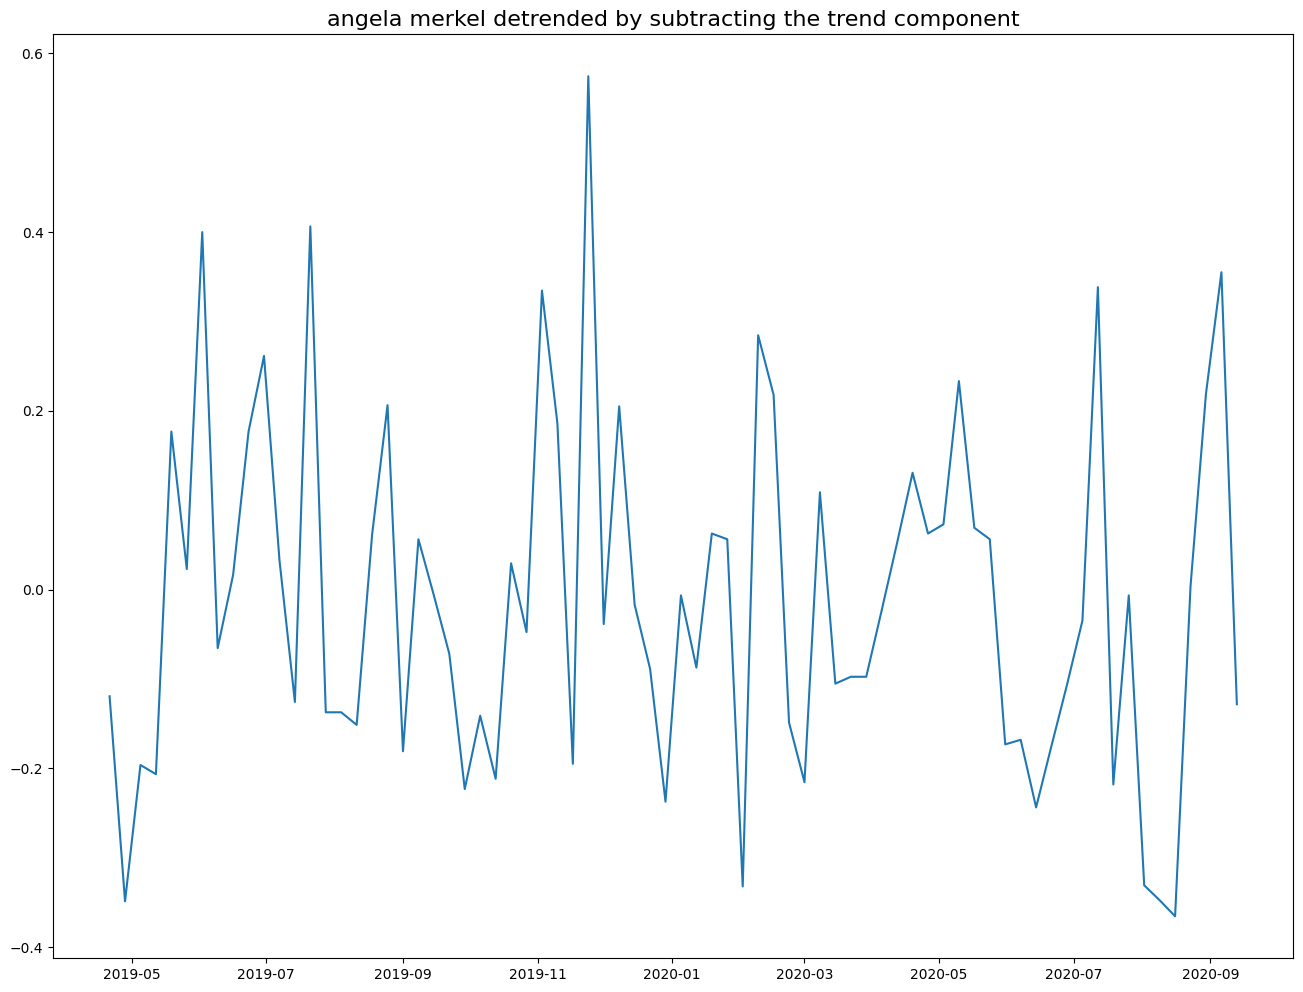

In [31]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(dw_scaled_nonull, model='multiplicative', period=30)
detrended = dw_scaled_nonull.values - result_mul.trend
plt.plot(detrended)
plt.title(selected_keyword+' detrended by subtracting the trend component', fontsize=16)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

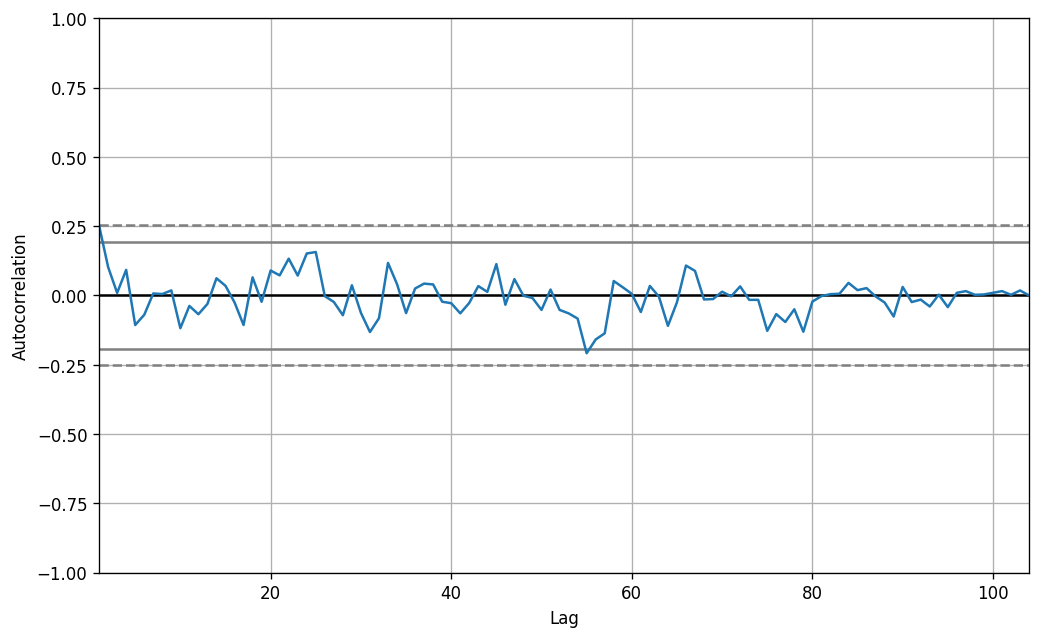

In [32]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(dw_scaled.tolist())
#autocorrelation_plot(detrended.tolist())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

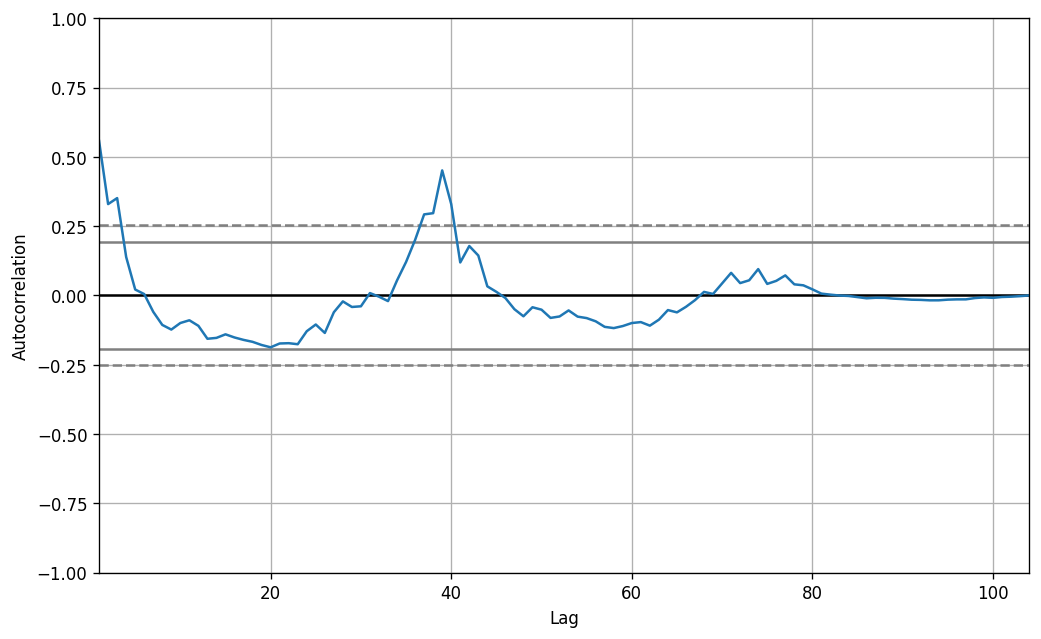

In [33]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(google_scaled.tolist())
#autocorrelation_plot(detrended.tolist())

/home/anya_m/Documents/venv/lib64/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



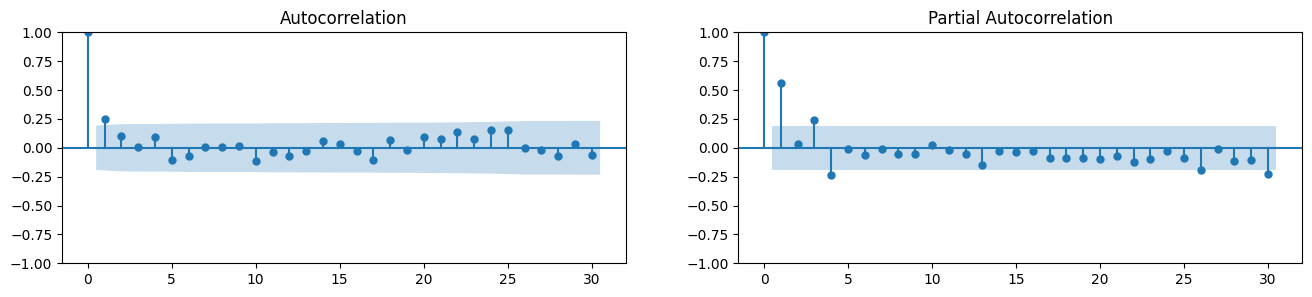

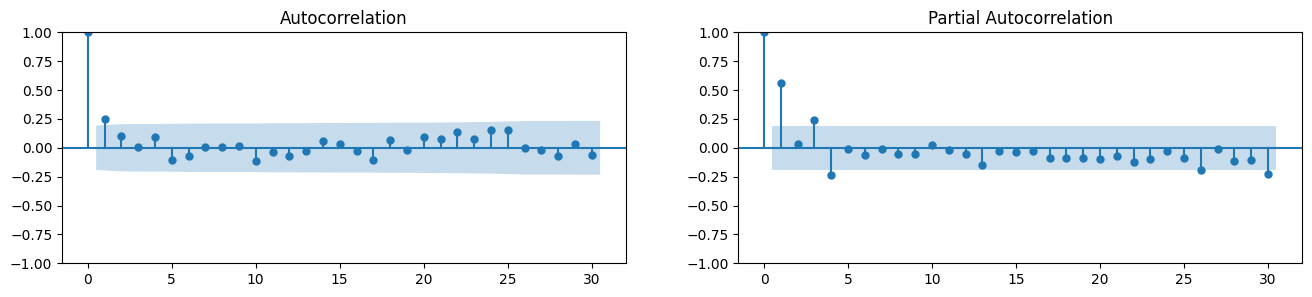

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(dw_scaled.tolist(), lags=30, ax=axes[0])
plot_pacf(google_scaled.tolist(), lags=30, ax=axes[1])

# plot_acf(detrended.tolist(), lags=50, ax=axes[0])
# plot_pacf(detrended.tolist(), lags=50, ax=axes[1])

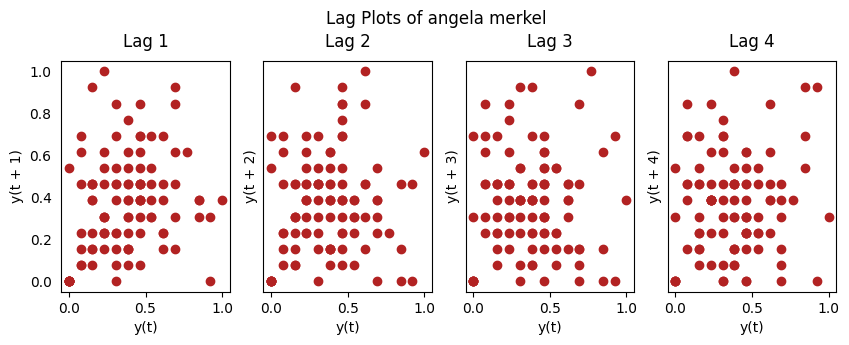

In [35]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(dw_scaled, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of ' + selected_keyword, y=1.05)    
plt.show()